In [120]:
import numpy as np
import networkx as nx
import lib.node2vec.node2vec as n2v
import os, csv

In [123]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from gensim.models import Word2Vec
from src.constants import STORE_LOCATION
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from src.constants import STORE_LOCATION

In [10]:
def read_graph(input, weighted=False, directed=False):
    '''
    Reads the input network in networkx.
    '''
    if weighted:
        G = nx.read_edgelist(input, nodetype=int, data=(('weight',float),), create_using=nx.DiGraph())
    else:
        G = nx.read_edgelist(input, nodetype=int, create_using=nx.DiGraph())
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = 1

    if not directed:
        G = G.to_undirected()

    return G

In [7]:
def learn_embeddings(walks):
    '''
    Learn embeddings by optimizing the Skipgram objective using SGD.
    '''
    walks = [map(str, walk) for walk in walks]
    model = Word2Vec(walks, size=args.dimensions, window=args.window_size,\
                     min_count=0, sg=1, workers=args.workers, iter=args.iter)
    model.save_word2vec_format(args.output)
    
    return

In [162]:
tag_dict = {}
with open(os.path.join(STORE_LOCATION, 'graphs/user-tag_keys.txt')) as tg_fl:
    for row in tg_fl:
        k, v = row.strip().split(',')
        tag_dict[float(v.strip())] = k

In [27]:
p, q = 0.25, 0.25

In [28]:
graph_loc = os.path.join(STORE_LOCATION, 'graphs/user-tag.txt')

In [25]:
nx_G = read_graph(graph_loc)

In [31]:
G = n2v.Graph(nx_G, False, p, q)

In [32]:
G.preprocess_transition_probs()

In [35]:
walks = G.simulate_walks(10, 80)

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


In [42]:
np.savez_compressed(os.path.join('data_temp/', 'user-tags-walks.npz'), np.array(walks))

In [40]:
walks = [map(str, walk) for walk in walks]

## Load walks

In [10]:
walks = np.load(os.path.join('data_temp/', 'user-tags-walks.npz'))

In [11]:
walks = walks['arr_0']

In [12]:
walks = walks.tolist()

## Word2Vec

In [1]:
w2v = Word2Vec(walks, size=80, window=8, min_count=0, sg=1, workers=8, iter=5)

NameError: name 'Word2Vec' is not defined

In [15]:
w2v.save_word2vec_format(os.path.join('data_temp/', 'user-tags-emb.emb'))

## Load w2v

In [4]:
w2v = Word2Vec.load_word2vec_format(os.path.join('data_temp/', 'user-tags-emb.emb'), binary=False)

## Clustering

In [250]:
inertias = []
for k in range(1, 100):
    kmeans = KMeans(n_clusters=k, n_jobs=-1, precompute_distances=True)
    kmeans.fit(w2v.syn0)
    inertias.append(kmeans.inertia_)

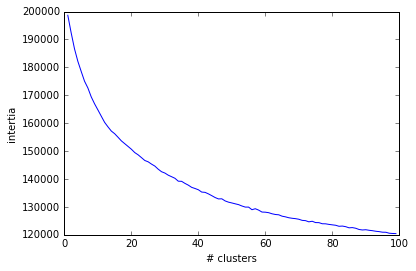

In [284]:
%matplotlib inline
plt.plot(range(1, 100), inertias)
plt.xlabel('# clusters')
plt.ylabel('intertia')

In [273]:
kmeans = KMeans(n_clusters=20, n_jobs=-1, precompute_distances=True)
kmeans.fit(w2v.syn0)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=20, n_init=10,
    n_jobs=-1, precompute_distances=True, random_state=None, tol=0.0001,
    verbose=0)

## T-SNE

In [ ]:
# np.set_printoptions(suppress=False)

tsne = TSNE(n_components=2, random_state=0, n_iter=500, init='pca')

Y_tsne = tsne.fit_transform(w2v.syn0)

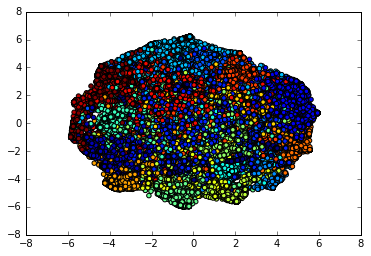

In [275]:
%matplotlib inline
plt.scatter(Y_tsne[:, 0], Y_tsne[:, 1], c=kmeans.labels_)

## PCA

In [254]:
pca = PCA(n_components=3)

Y_pca = pca.fit_transform(w2v.syn0)

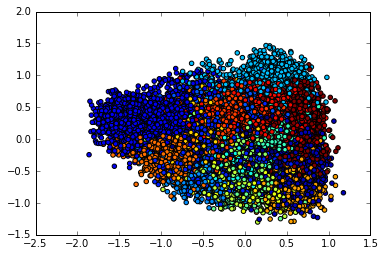

In [276]:
plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c=kmeans.labels_)

In [206]:
tag_ids = [v for v in w2v.vocab.keys() if int(v)>=1000000]

In [207]:
tag_idxs = [w2v.vocab[v].index for v in tag_ids]

In [208]:
Y_pca_tags = Y_pca[tag_idxs]

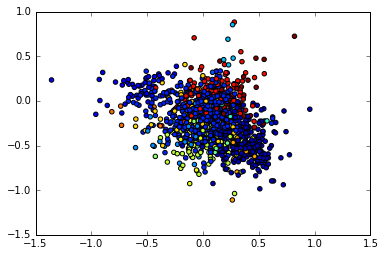

In [277]:
%matplotlib inline
plt.scatter(Y_pca_tags[:, 0], Y_pca_tags[:, 1], c=kmeans.labels_[tag_idxs])

<IPython.core.display.Javascript object>


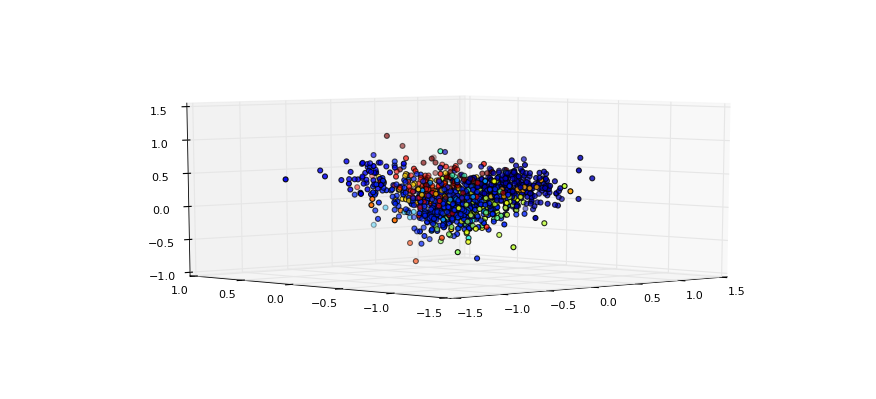

In [285]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Y_pca_tags[:, 0], Y_pca_tags[:, 1], Y_pca_tags[:, 2], c=kmeans.labels_[tag_idxs])
plt.draw()

In [281]:
tag_clusters = {}
for t_id, clt in zip(tag_idxs, kmeans.labels_[tag_idxs]):
    tag_name = tag_dict[float(w2v.index2word[t_id])]
    
    if clt in tag_clusters:
        tag_clusters[clt].append(tag_name)
    else:
        tag_clusters[clt] = [tag_name]

In [282]:
tag_clusters

{0: ['relations',
  'discrete-mathematics',
  'equivalence-relations',
  'elementary-set-theory',
  'cardinals',
  'functions'],
 1: ['derived-functors',
  '4-manifolds',
  'topological-rings',
  'tensors',
  'riemann-sphere',
  'holonomy',
  'lie-algebras',
  'fundamental-groups',
  'kirby-diagram',
  'compact-manifolds',
  'arithmetic-geometry',
  'enriched-category-theory',
  'riemann-surfaces',
  'operads',
  'groupoids',
  'rngs',
  'quantum-field-theory',
  'pfaffian',
  'analytic-spread',
  'homotopy-theory',
  'galois-representations',
  'quiver',
  'jet-bundles',
  'manifolds-with-boundary',
  'differential-geometry',
  'group-rings',
  'homological-algebra',
  'quasicoherent-sheaves',
  'fiber-bundles',
  'equivariant-cohomology',
  'cw-complexes',
  'hilbert-polynomial',
  'additive-categories',
  'galois-cohomology',
  'gaussian-integers',
  'deformation-theory',
  'moduli-space',
  'low-dimensional-topology',
  'knot-theory',
  'almost-complex',
  'subgroup-growth',
  'gro

In [286]:
inertias = []
for k in range(1, 100):
    kmeans = KMeans(n_clusters=k, n_jobs=-1, precompute_distances=True)
    kmeans.fit(w2v.syn0[tag_idxs])
    inertias.append(kmeans.inertia_)

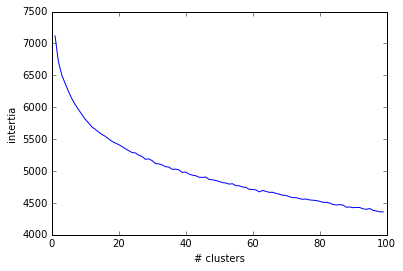

In [287]:
%matplotlib inline
plt.plot(range(1, 100), inertias)
plt.xlabel('# clusters')
plt.ylabel('intertia')